In [1]:
import mitsuba as mi
mi.set_variant("llvm_ad_mono_polarized")
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera, RadioMapSolver, PathSolver
import sionna.rt as rt
import matplotlib.pyplot as plt
# "C:\Program Files\Blender Foundation\Blender 4.2\blender.exe" --python-use-system-env

In [2]:
from xml.etree import ElementTree as ET

xml_path = r"/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/chicagoMariona.xml"
tree = ET.parse(xml_path)
root = tree.getroot()

def to_radio(bsdf_elem, radio_type):
    bsdf_elem.set("type", "itu-radio-material")
    # elimina hijos anteriores
    for c in list(bsdf_elem):
        bsdf_elem.remove(c)
    t = ET.SubElement(bsdf_elem, "string")
    t.set("name", "type")
    t.set("value", radio_type)

for bsdf in root.findall(".//bsdf"):
    t = bsdf.get("type")
    bid = bsdf.get("id", "")
    if t in ("diffuse", "twosided", "conductor", "plastic", "roughconductor"):
        if "wall" in bid:
            to_radio(bsdf, "concrete")
        elif "roof" in bid:
            to_radio(bsdf, "metal")
        else:
            # fallback razonable; cambia a 'glass' si son ventanas
            to_radio(bsdf, "concrete")

tree.write(r"/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/ChicagoMarionaClean.xml", encoding="utf-8", xml_declaration=True)

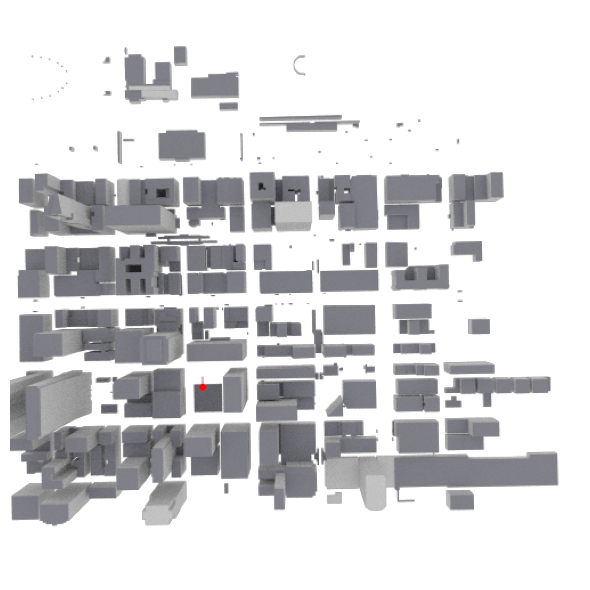

In [2]:
scene_path = r"/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/ChicagoMarionaClean.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)
scene.frequency = 1.57542e9

# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
# for i in range(1):
        # tx = Transmitter(name=f"Tx{i+1}", position=[-900-190, 400, 10], color=[1.0, 0.0, 0.0])
        # scene.add(tx)
tx = Transmitter(name="Tx1", position=[-200, 200, 10], color=[1.0, 0.0, 0.0], power_dbm=10)
scene.add(tx)
# Visualize scene with transmitter and receivers in place
cam = Camera(position=(-0.0, 0.0, 1500.0))
cam.look_at((-0.0,0.0,-0.0))
scene.render(camera=cam, show_orientations=True, resolution=(500,500))

Min log values: -369.8095703125


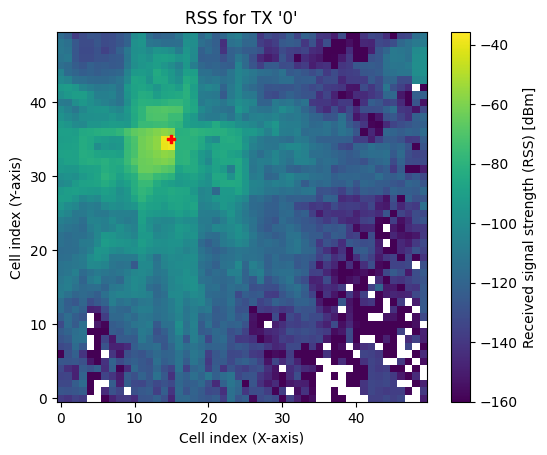

In [3]:
x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

rm = rm_solver(
    scene,
    max_depth=100,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

rm.show(metric="rss", tx=0, show_tx=True, vmin=-160)

rss = np.array(rm.rss)
print("Min log values:", 10*np.log10(np.min(rss[rss>0])))

In [4]:
print(len(scene.objects))
for i, name in enumerate(scene.objects.keys(), 1):
    print(f"{i}. {name}")

20
1. elm__808
2. no-name-1
3. elm__285
4. elm__243
5. elm__273
6. no-name-2
7. no-name-3
8. elm__212
9. no-name-4
10. elm__176
11. elm__26
12. elm__29
13. no-name-5
14. elm__111
15. elm__122
16. elm__112
17. no-name-6
18. no-name-7
19. elm__27
20. no-name-8


In [8]:
print(scene.get("elm__808").mi_mesh.bbox())

BoundingBox3f[
  min = [190.957, 252.246, -0.00076142],
  max = [244.17, 313.9, 61.173]
]


In [ ]:
#--------------------------Visualize RadioMap Data in 3D----------------------------#

dbm_receivers = -40
positions, cell_indices = rm.sample_positions(
    num_pos=50,
    metric='rss',
    max_val_db=dbm_receivers, # dbm for RSS!!
    min_dist=100,
    max_dist=1000,
    tx_association=True
)

# Convert to numpy and add receivers at those positions
positions = positions.numpy().squeeze() # Shape: [10, 3]

# Extract RadioMap data
path_gain = np.array(rm.path_gain)  # Shape: [num_tx, cells_y, cells_x]
rss_data = path_gain[0, :, :]  # Get first transmitter

# Convert to dBm
power_grid_dbm = 10 * np.log10(rss_data + 1e-16) + 30 

# Create coordinate grids
num_cells_y, num_cells_x = power_grid_dbm.shape
x_coords = np.linspace(x_min, x_max, num_cells_x)
y_coords = np.linspace(y_min, y_max, num_cells_y)
X, Y = np.meshgrid(x_coords, y_coords)

# Create 3D surface plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, power_grid_dbm, cmap='viridis', edgecolor='none', alpha=0.9)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Power (dB)')
ax.set_title('Received Power Coverage (3D) - RadioMap')

tx_pos = tx.position[:2]
ax.scatter([tx_pos[0]], [tx_pos[1]], [power_grid_dbm.max()], 
           color='red', s=300, marker='*', label='Tx1', 
           edgecolors='white', linewidths=2)

# add vertical dashed line in 0,0
ax.plot([0, 0], [0, 0], [power_grid_dbm.min(), power_grid_dbm.max()],  color='black', linestyle='--', linewidth=1)

# Add sampled receiver positions
if len(positions) > 0:
    ax.scatter(positions[:, 0], positions[:, 1], [dbm_receivers] * len(positions),
               color='black', s=100, marker='o', label='Sampled Rx',
               edgecolors='black', linewidths=1)

fig.colorbar(surf, ax=ax, shrink=0.5, label='Power (dBm)')
ax.legend()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(power_grid_dbm.min(), power_grid_dbm.max())
plt.tight_layout()
plt.show()

print(f"\nPower range: {power_grid_dbm.min():.2f} to {power_grid_dbm.max():.2f} dBm")

In [ ]:
import numpy as np
import plotly.graph_objects as go

dbm_receivers = -20
positions, cell_indices = rm.sample_positions(
    num_pos=50,
    metric='rss',
    min_val_db=dbm_receivers, # dbm for RSS!!
    min_dist=0,
    max_dist=1000,
    tx_association=True
)

# Convert to numpy and add receivers at those positions
positions = positions.numpy().squeeze() # Shape: [10, 3]

# Convert to dBm
power_grid_dbm = 10 * np.log10(np.array(rm.path_gain)[0, :, :] + 1e-16) + 30 

# Create coordinate grids
num_cells_y, num_cells_x = power_grid_dbm.shape
x_coords = np.linspace(x_min, x_max, num_cells_x)
y_coords = np.linspace(y_min, y_max, num_cells_y)
X, Y = np.meshgrid(x_coords, y_coords)

# Build the surface
surf = go.Surface(
    x=X, y=Y, z=power_grid_dbm,
    colorscale="Viridis",
    showscale=True,
    colorbar=dict(title="Power (dBm)")
)

# Tx marker
tx_pos = np.array(tx.position[:2])
tx_trace = go.Scatter3d(
    x=[tx_pos[0]], y=[tx_pos[1]], z=[power_grid_dbm.max()],
    mode="markers",
    marker=dict(size=10, symbol="x", line=dict(width=2), color="red"),
    name="Tx1"
)

# Vertical dashed line at origin
origin_line = go.Scatter3d(
    x=[0, 0], y=[0, 0], z=[power_grid_dbm.min(), power_grid_dbm.max()],
    mode="lines",
    line=dict(width=2, dash="dash", color="black"),
    name="Origin"
)

# Sampled Rx points (projected at dbm_receivers for visibility)
rx_trace = None
if positions is not None and len(positions) > 0:
    rx_trace = go.Scatter3d(
        x=positions[:, 0],
        y=positions[:, 1],
        z=np.full(len(positions), dbm_receivers),
        mode="markers",
        marker=dict(size=4, color="black"),
        name="Sampled Rx"
    )

fig = go.Figure(data=[surf, tx_trace, origin_line] + ([rx_trace] if rx_trace else []))

# Layout and axes
zmin = float(np.nanmin(power_grid_dbm))
zmax = float(np.nanmax(power_grid_dbm))

fig.update_layout(
    title="Received Power Coverage (3D) — RadioMap",
    scene=dict(
        xaxis_title="X (m)",
        yaxis_title="Y (m)",
        zaxis_title="Power (dBm)",
        xaxis=dict(range=[x_min, x_max], gridcolor="lightgray", zeroline=False),
        yaxis=dict(range=[y_min, y_max], gridcolor="lightgray", zeroline=False),
        zaxis=dict(range=[zmin, zmax], gridcolor="lightgray"),
        camera=dict(eye=dict(x=1.6, y=1.6, z=1.0))
    ),
    margin=dict(l=0, r=0, t=40, b=0),
)

# Hover content
fig.update_traces(
    hovertemplate="x=%{x:.1f} m<br>y=%{y:.1f} m<br>P=%{z:.2f} dBm",
    selector=dict(type="surface")
)

fig.show()
fig.write_html("radio_map_3d_sionna.html")
print(f"Power range: {zmin:.2f} to {zmax:.2f} dBm")


In [ ]:
scene.preview(radio_map=rm, rm_vmin=-160, resolution=(500, 500))

In [ ]:
from scipy.io import loadmat
from scipy.interpolate import griddata, RegularGridInterpolator

X_matlab = loadmat(f'/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/X.mat')['XX']
y_matlab = loadmat(f'/home/luisg-ubuntu/sionna_rt_jamming/data/downtown_chicago_luis/Y.mat')['YY'].ravel()

mask = y_matlab < -160
y_matlab[mask] = -160

# Define grid bounds and create a uniform grid
x_min, x_max = X_matlab[:, 0].min(), X_matlab[:, 0].max()
y_min, y_max = X_matlab[:, 1].min(), X_matlab[:, 1].max()
x_grid = np.linspace(x_min, x_max, 1000)
y_grid = np.linspace(y_min, y_max, 1000)
grid_x, grid_y = np.meshgrid(x_grid, y_grid, indexing='ij')

# Precompute the interpolated grid values using griddata
grid_z = griddata(X_matlab, y_matlab, (grid_x, grid_y), method='linear', fill_value=np.min(y_matlab))

# Create a RegularGridInterpolator for fast evaluation and sampling
interpolator = RegularGridInterpolator(
    (x_grid, y_grid), grid_z,
    method='linear', bounds_error=False, fill_value=-160
)

# plot the interpolated radio map using plotly
import plotly.graph_objects as go
fig = go.Figure()
surf = go.Surface(
    x=grid_x,
    y=grid_y,
    z=grid_z,
    colorscale="Viridis",
    showscale=True,
    colorbar=dict(title="Power (dBm)")
)
fig.add_trace(surf)
fig.show()
fig.write_html("interpolated_radio_map_matlab.html")

In [ ]:
from scipy.interpolate import RegularGridInterpolator

In [ ]:
# compute the error surface between the matlab data and rss
power_grid_dbW = 10 * np.log10(np.array(rm.path_gain)[0, :, :] + 1e-16)

ny_src, nx_src = power_grid_dbW.shape  # ojo: muchas veces es (y, x)
x_src = np.linspace(x_min, x_max, nx_src)
y_src = np.linspace(y_min, y_max, ny_src)

power_grid_dbW = RegularGridInterpolator(
    (y_src, x_src),           # (eje 0, eje 1) → (fila, columna) → (y, x)
    power_grid_dbW,           # shape (ny_src, nx_src)
    bounds_error=False,
    fill_value=np.min(power_grid_dbW)
)(np.stack([grid_y.ravel(), grid_x.ravel()], axis=-1)).reshape(grid_x.shape)

error_surface = grid_z - power_grid_dbW

# plot with plotly
fig = go.Figure()
surf = go.Surface(
    x=grid_x,
    y=grid_y,
    z=error_surface,
    colorscale="Viridis",
    showscale=True,
    colorbar=dict(title="Error (dB)")
)
fig.add_trace(surf)
fig.update_layout(
    title=f"Mean Absolute Error: {np.mean(np.abs(error_surface)):.2f} dB",
    width=900,          # adjust as needed
    height=700,         # adjust as needed
    margin=dict(l=0, r=0, b=0, t=50),  # remove white space
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Error (dB)",
        aspectmode="data"  # preserves axis scale, less empty space
    )
)
fig.show()
# save html
fig.write_html("error_surface_radio_map.html")